In [1]:
import pandas as pd
from xgboost import DMatrix

from src.helper import get_split_data

In [2]:
X_trn, y_trn, X_val, y_val, X_tst, y_tst = get_split_data.split_data_for_training(3, 'data/preprocessed/preprocessed_1.csv')

X = pd.concat([X_trn, X_val], axis='index')
y = pd.Series([*y_trn, *y_val], index=X.index)

In [3]:
# X_trn.drop(['away_last_team_possession', 'points_diff_accel_away','points_diff_segment_encoded', 'points_diff_accel_home_cat', 'away_last_team_goal', 'points_diff_accel_away_x_goals_ratio_away','team_acceleration_home_cat', 'home_last_team_goal', 'points_difference'], axis=1, inplace=True)
# X_val.drop(['away_last_team_possession', 'points_diff_accel_away','points_diff_segment_encoded', 'points_diff_accel_home_cat', 'away_last_team_goal', 'points_diff_accel_away_x_goals_ratio_away','team_acceleration_home_cat', 'home_last_team_goal', 'points_difference'], axis=1, inplace=True)
# X_tst.drop(['away_last_team_possession', 'points_diff_accel_away','points_diff_segment_encoded', 'points_diff_accel_home_cat', 'away_last_team_goal', 'points_diff_accel_away_x_goals_ratio_away','team_acceleration_home_cat', 'home_last_team_goal', 'points_difference'], axis=1, inplace=True)

In [4]:
from sklearn.metrics import f1_score
import xgboost as xgb

params = {'colsample_bytree': 0.8942111366085129,
          'gamma': 2.0871387575947242,
          'learning_rate': 0.309599660922321,
          'max_depth': 8,
          'n_estimators': 600,
          'reg_alpha': 0.0261422004555746,
          'reg_lambda': 0.08425350261267016,
          'subsample': 0.8477303914222476
          }

y_train_value_counts = y_trn.value_counts()
ratio = y_train_value_counts[0] / y_train_value_counts[1]

model = xgb.XGBClassifier(
    **params,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=ratio
)

model.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=False)
y_pred_ = model.predict(X_tst)

y_pred_proba = model.predict_proba(X_tst)

custom_threshold = 0.5
y_pred = (y_pred_proba[:, 1] > custom_threshold).astype(int)

print(y_pred)

f1 = f1_score(y_tst, y_pred, average="binary")
f1

[0 0 1 0 0 0 0 0 0 1]


np.float64(0.4)

In [5]:
import shap

shap.initjs()
shap_ex = shap.TreeExplainer(model)
vals = shap_ex(X_tst)

shap_df = pd.DataFrame(vals.values, columns=X_tst.columns)
# print(shap_df)

In [6]:
import numpy as np

print(pd.concat([shap_df.sum(axis='columns').rename('pred') + vals.base_values,
                 pd.Series(y_pred, name='predicted values'),
                 pd.Series(y_tst, name='true values')], axis='columns')
      .assign(prob=lambda adf: (np.exp(adf.pred) / (1 + np.exp(adf.pred))))
      )

       pred  predicted values  true values      prob
0 -0.343003                 0            0  0.415080
1 -1.576370                 0            0  0.171310
2  2.069204                 1            0  0.887874
3 -0.961624                 0            0  0.276553
4 -0.193862                 0            0  0.451686
5 -2.329161                 0            1  0.088737
6 -0.526776                 0            0  0.371269
7 -0.165552                 0            0  0.458706
8 -0.711049                 0            1  0.329367
9  0.328422                 1            1  0.581375


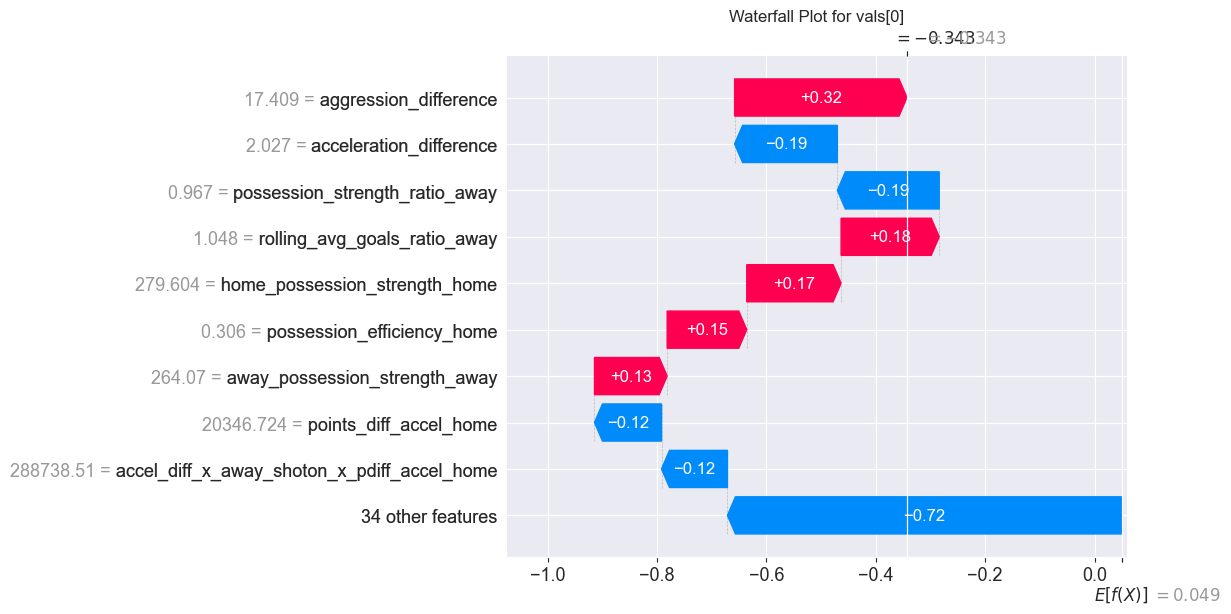

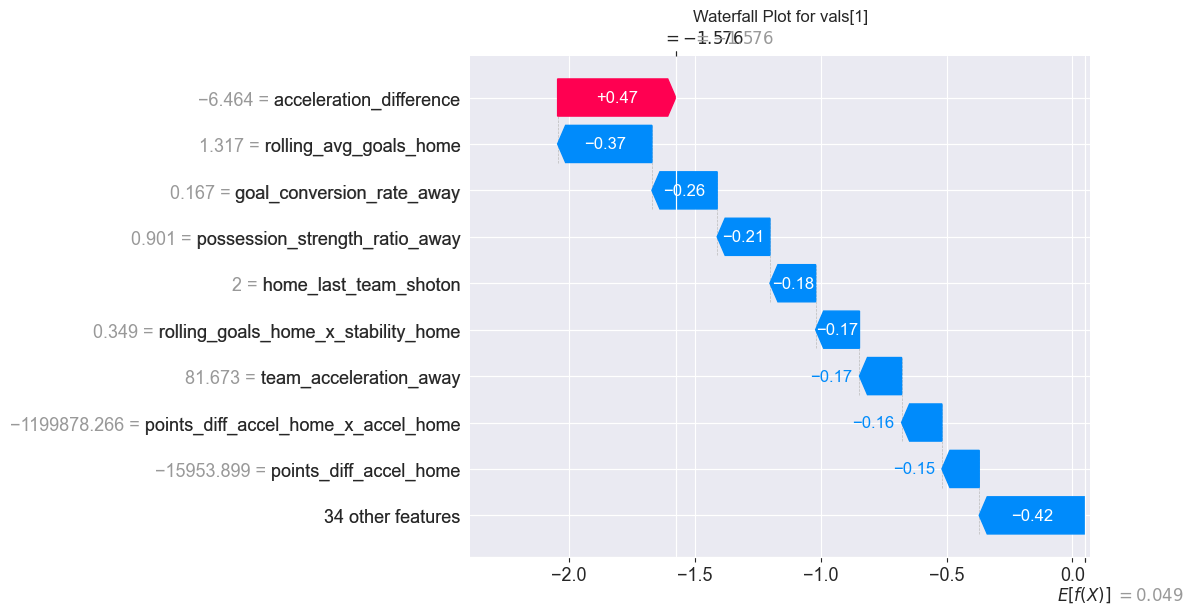

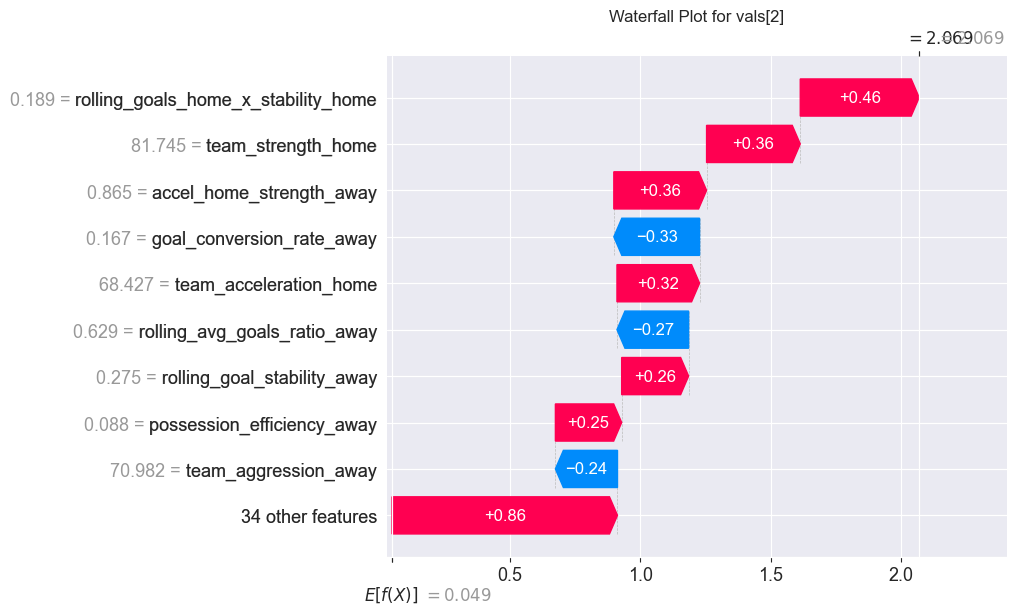

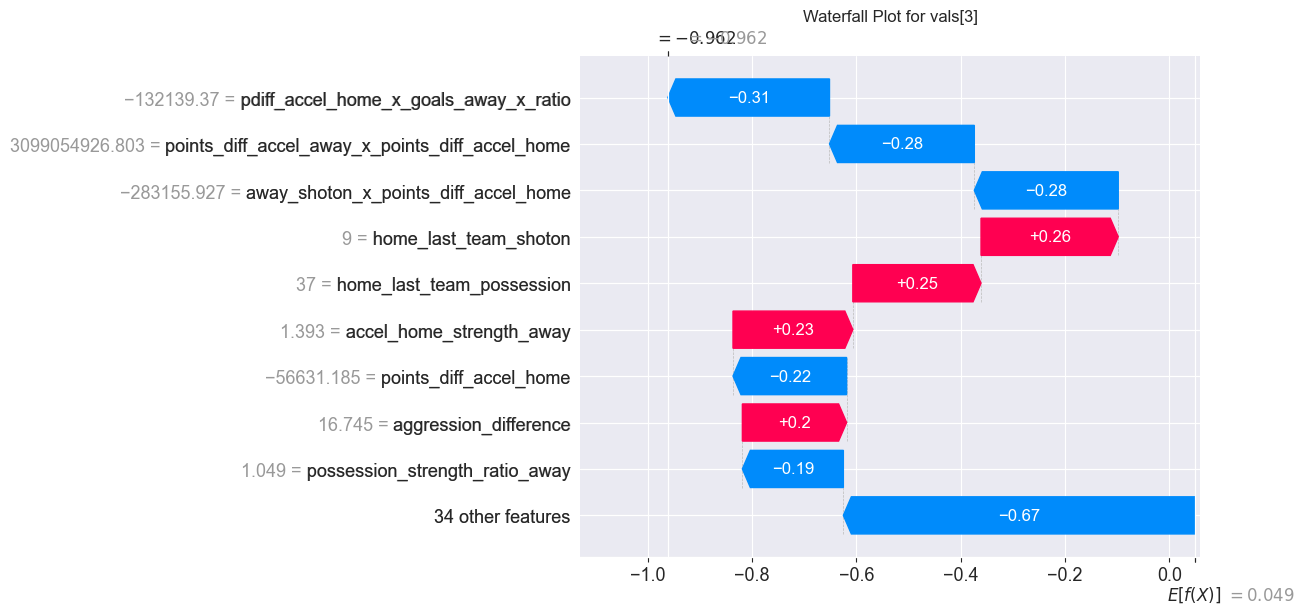

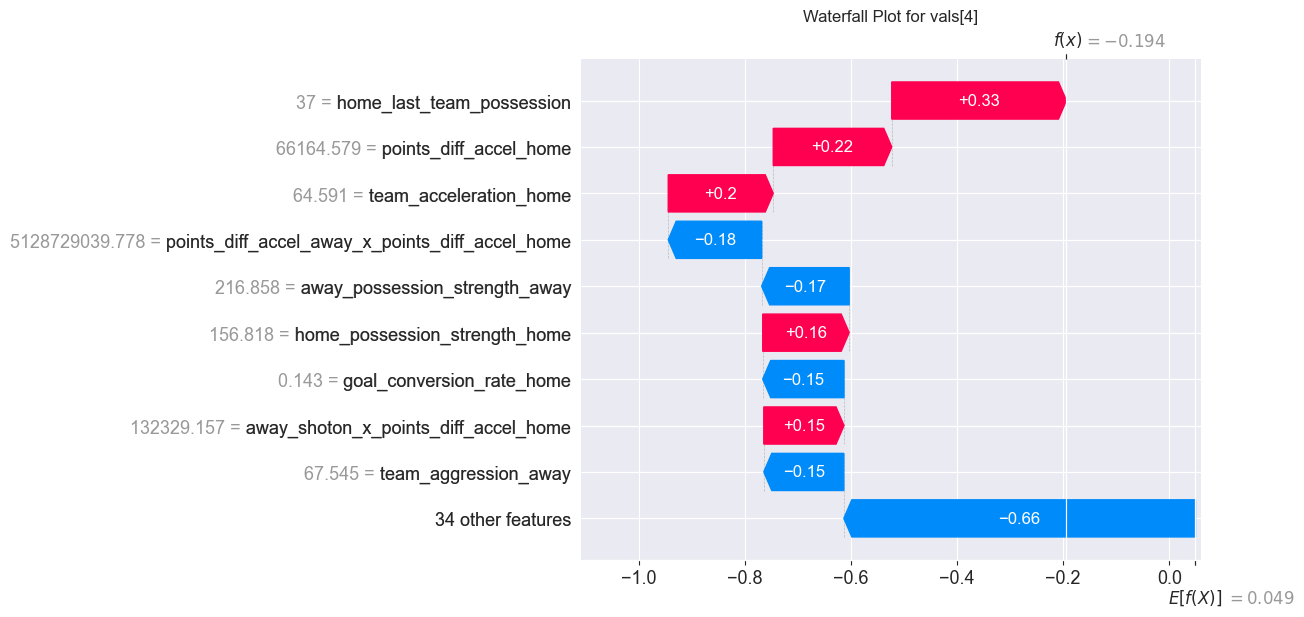

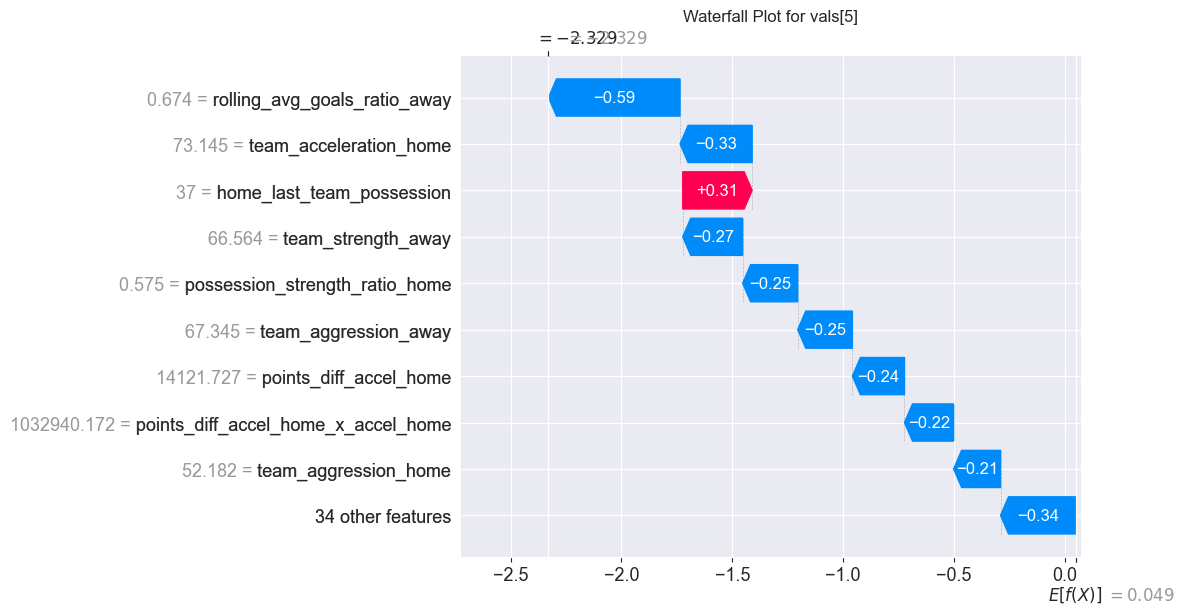

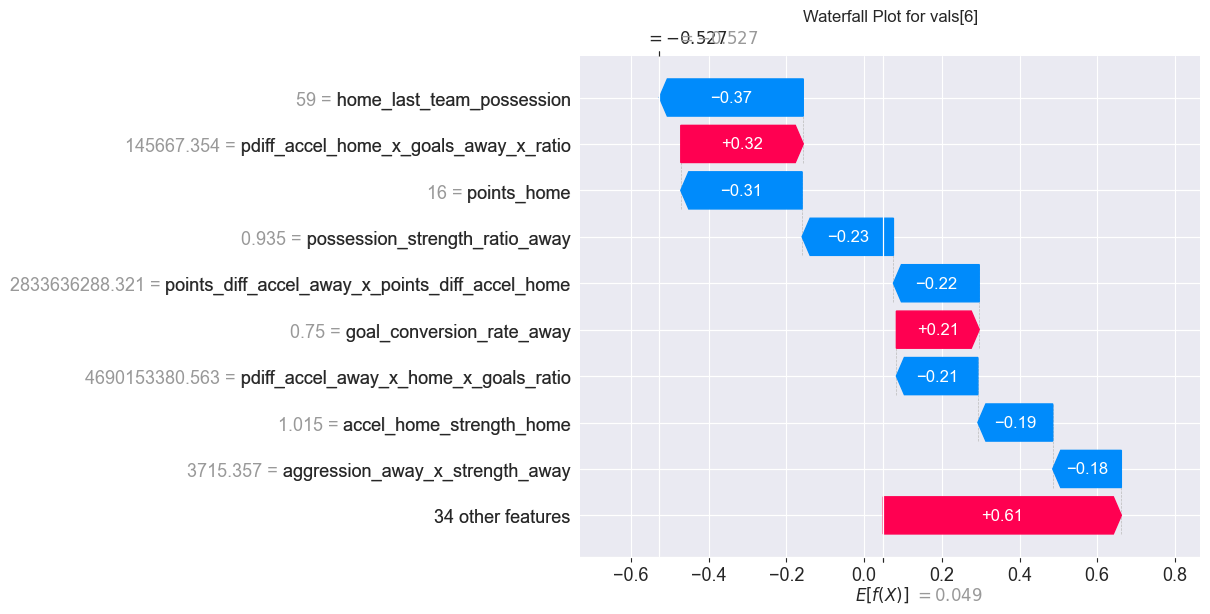

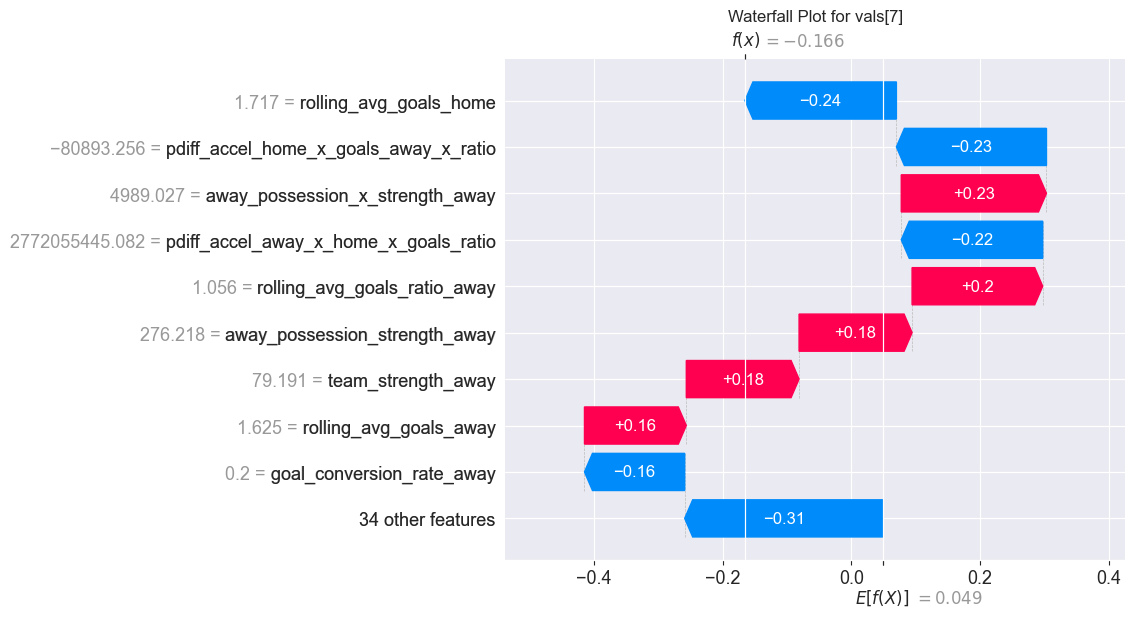

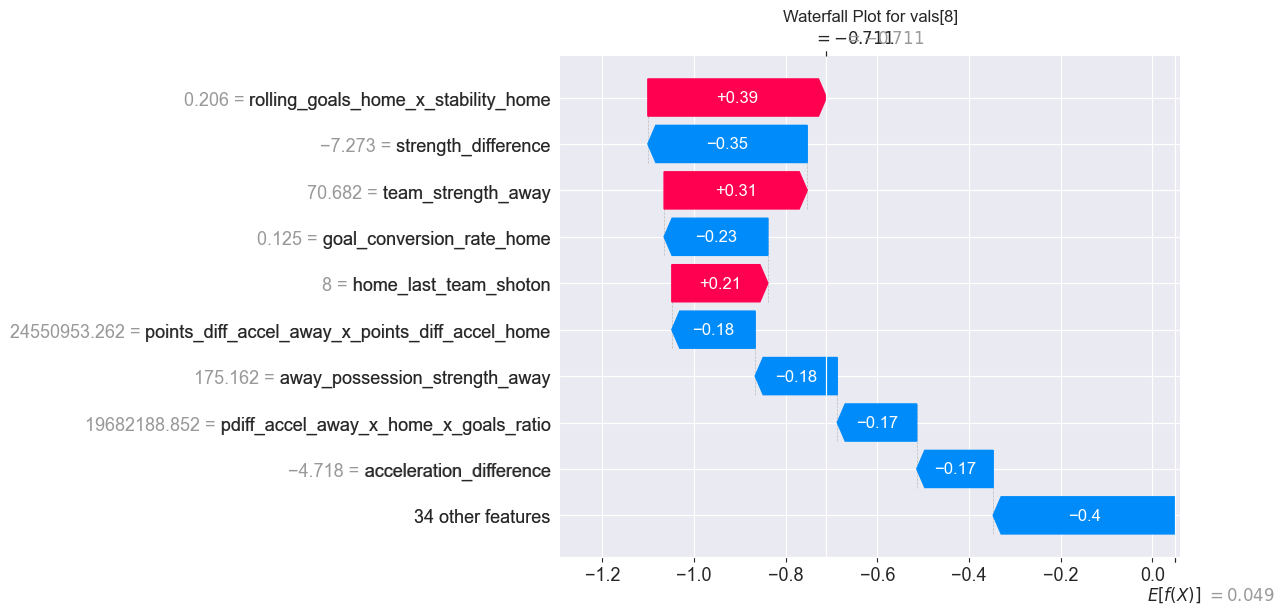

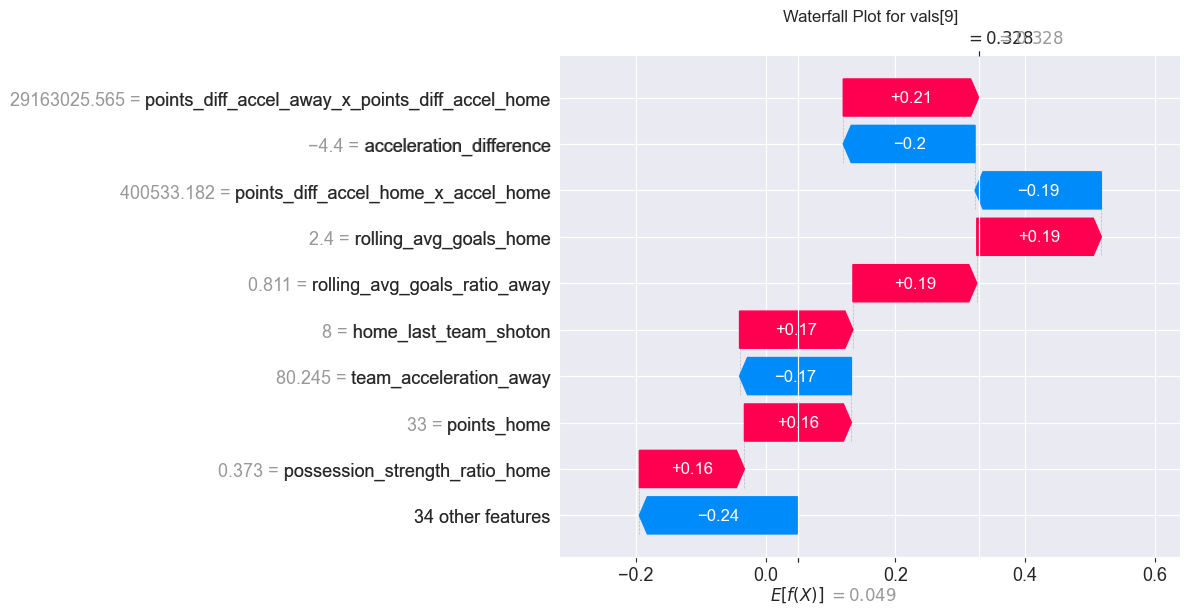

In [7]:
from matplotlib import pyplot as plt

for i, val in enumerate(vals):
    fig = plt.figure(figsize=(8, 4))
    shap.plots.waterfall(val, show=False)
    plt.title(f"Waterfall Plot for vals[{i}]")
    plt.show()

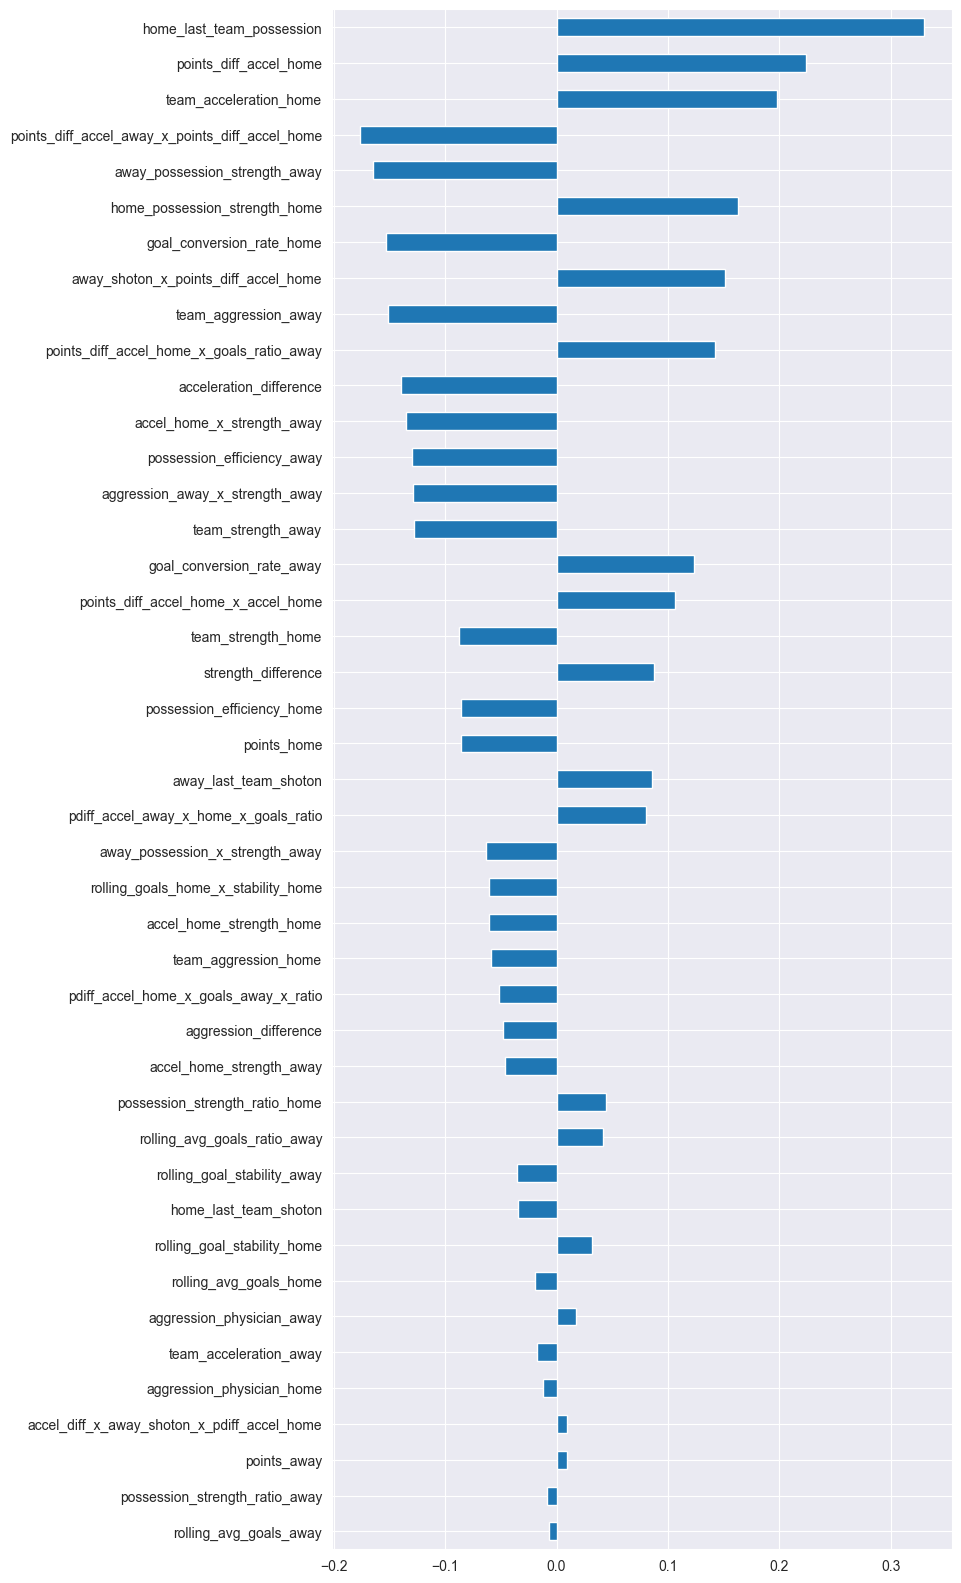

In [8]:
fig, ax = plt.subplots(figsize=(8, 20))
(pd.Series(vals.values[4], index=X_tst.columns)
 .sort_values(key=np.abs)
 .plot.barh(ax=ax)
 )
plt.show()

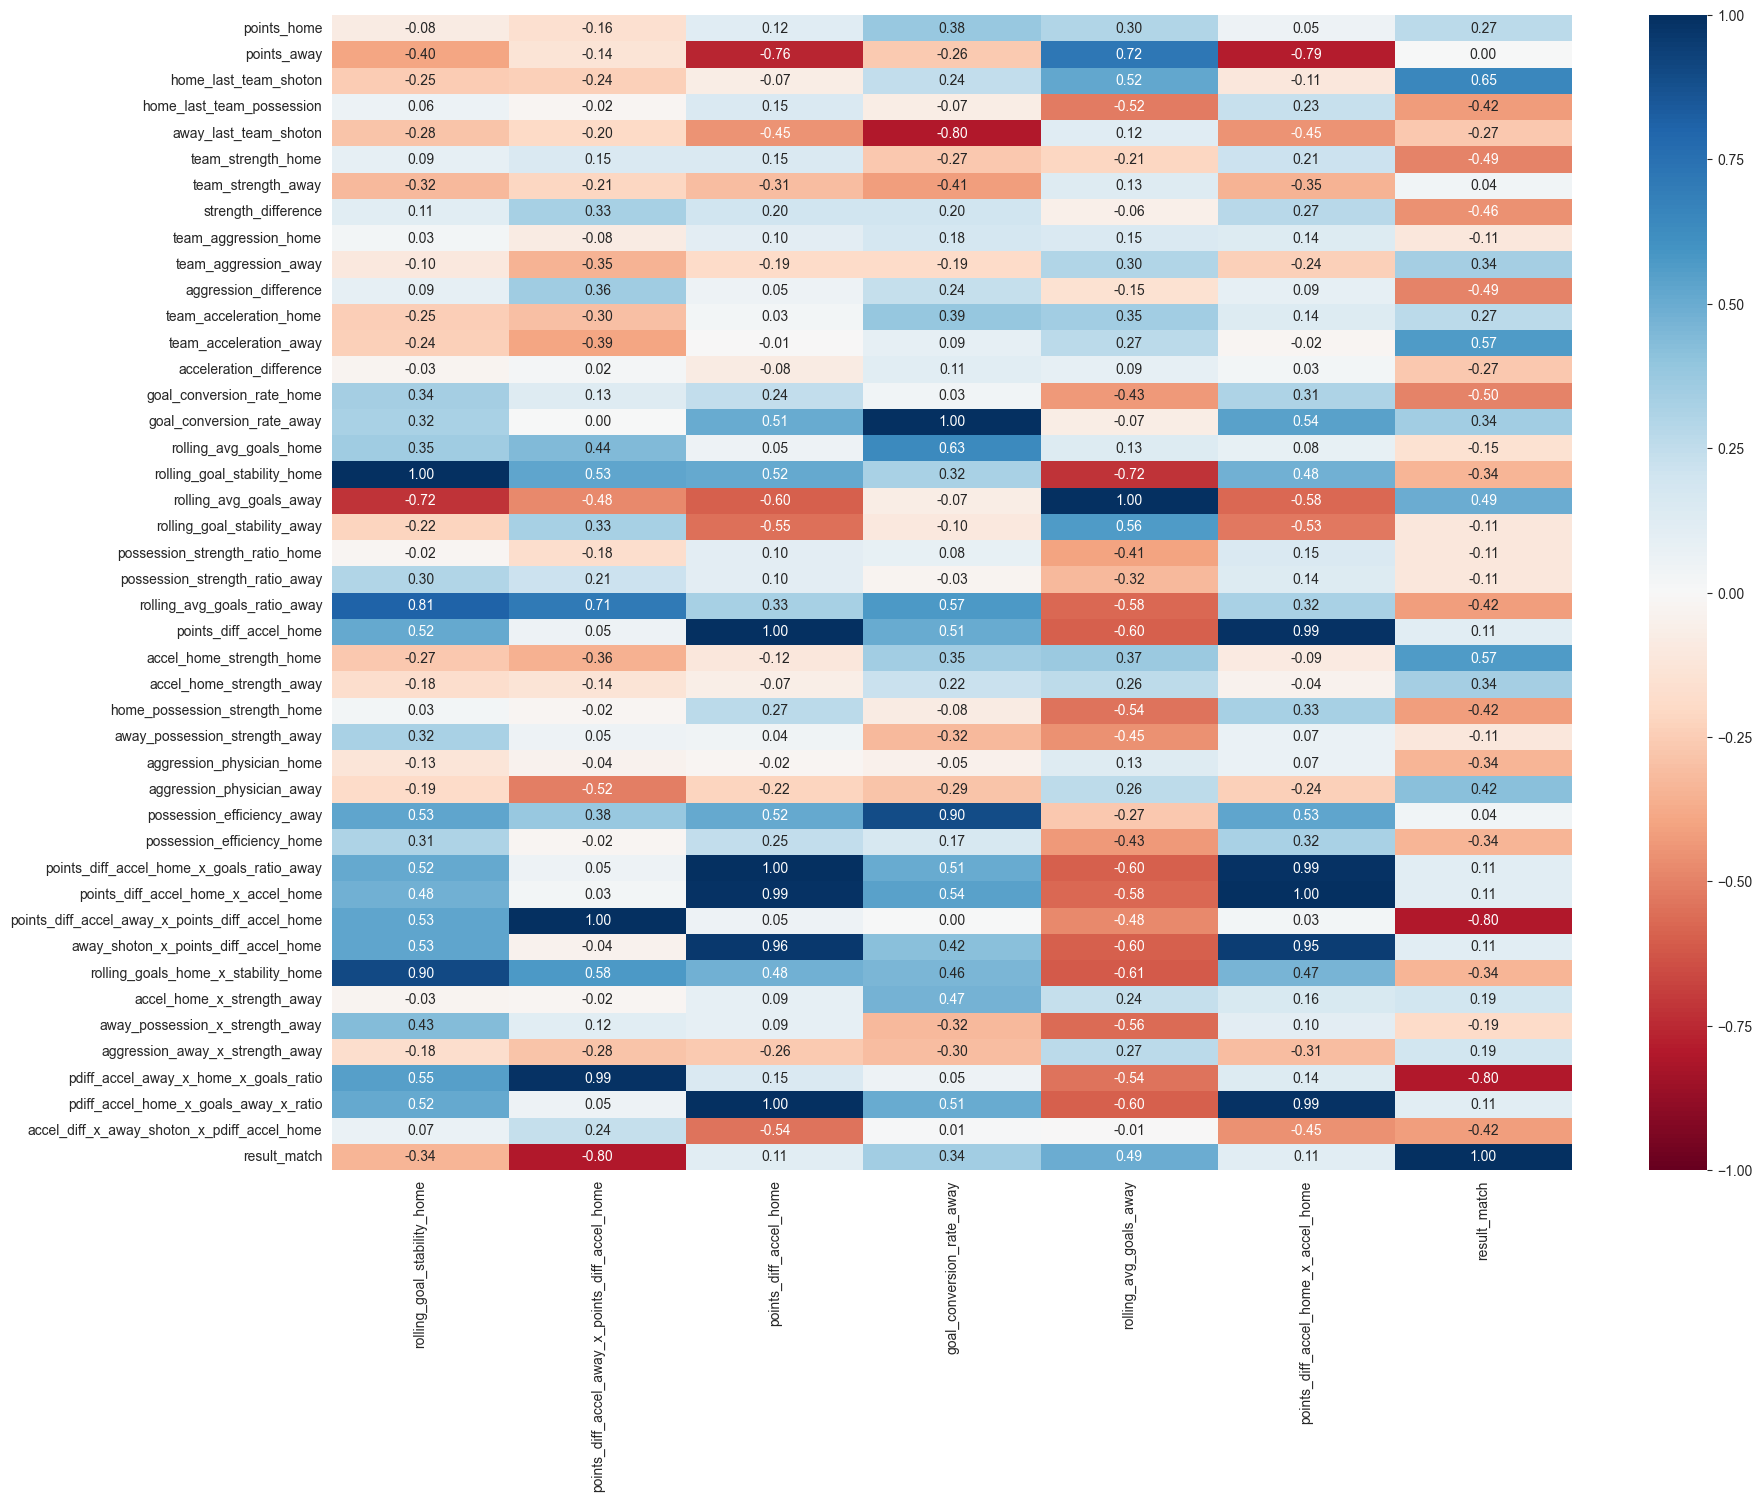

In [9]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(X_tst
            .assign(result_match=y_tst)
            .corr(method='spearman')
            .loc[:,
            ['rolling_goal_stability_home', 'points_diff_accel_away_x_points_diff_accel_home', 'points_diff_accel_home',
             'goal_conversion_rate_away', 'rolling_avg_goals_away', 'points_diff_accel_home_x_accel_home',
             'result_match']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
            )
plt.show()

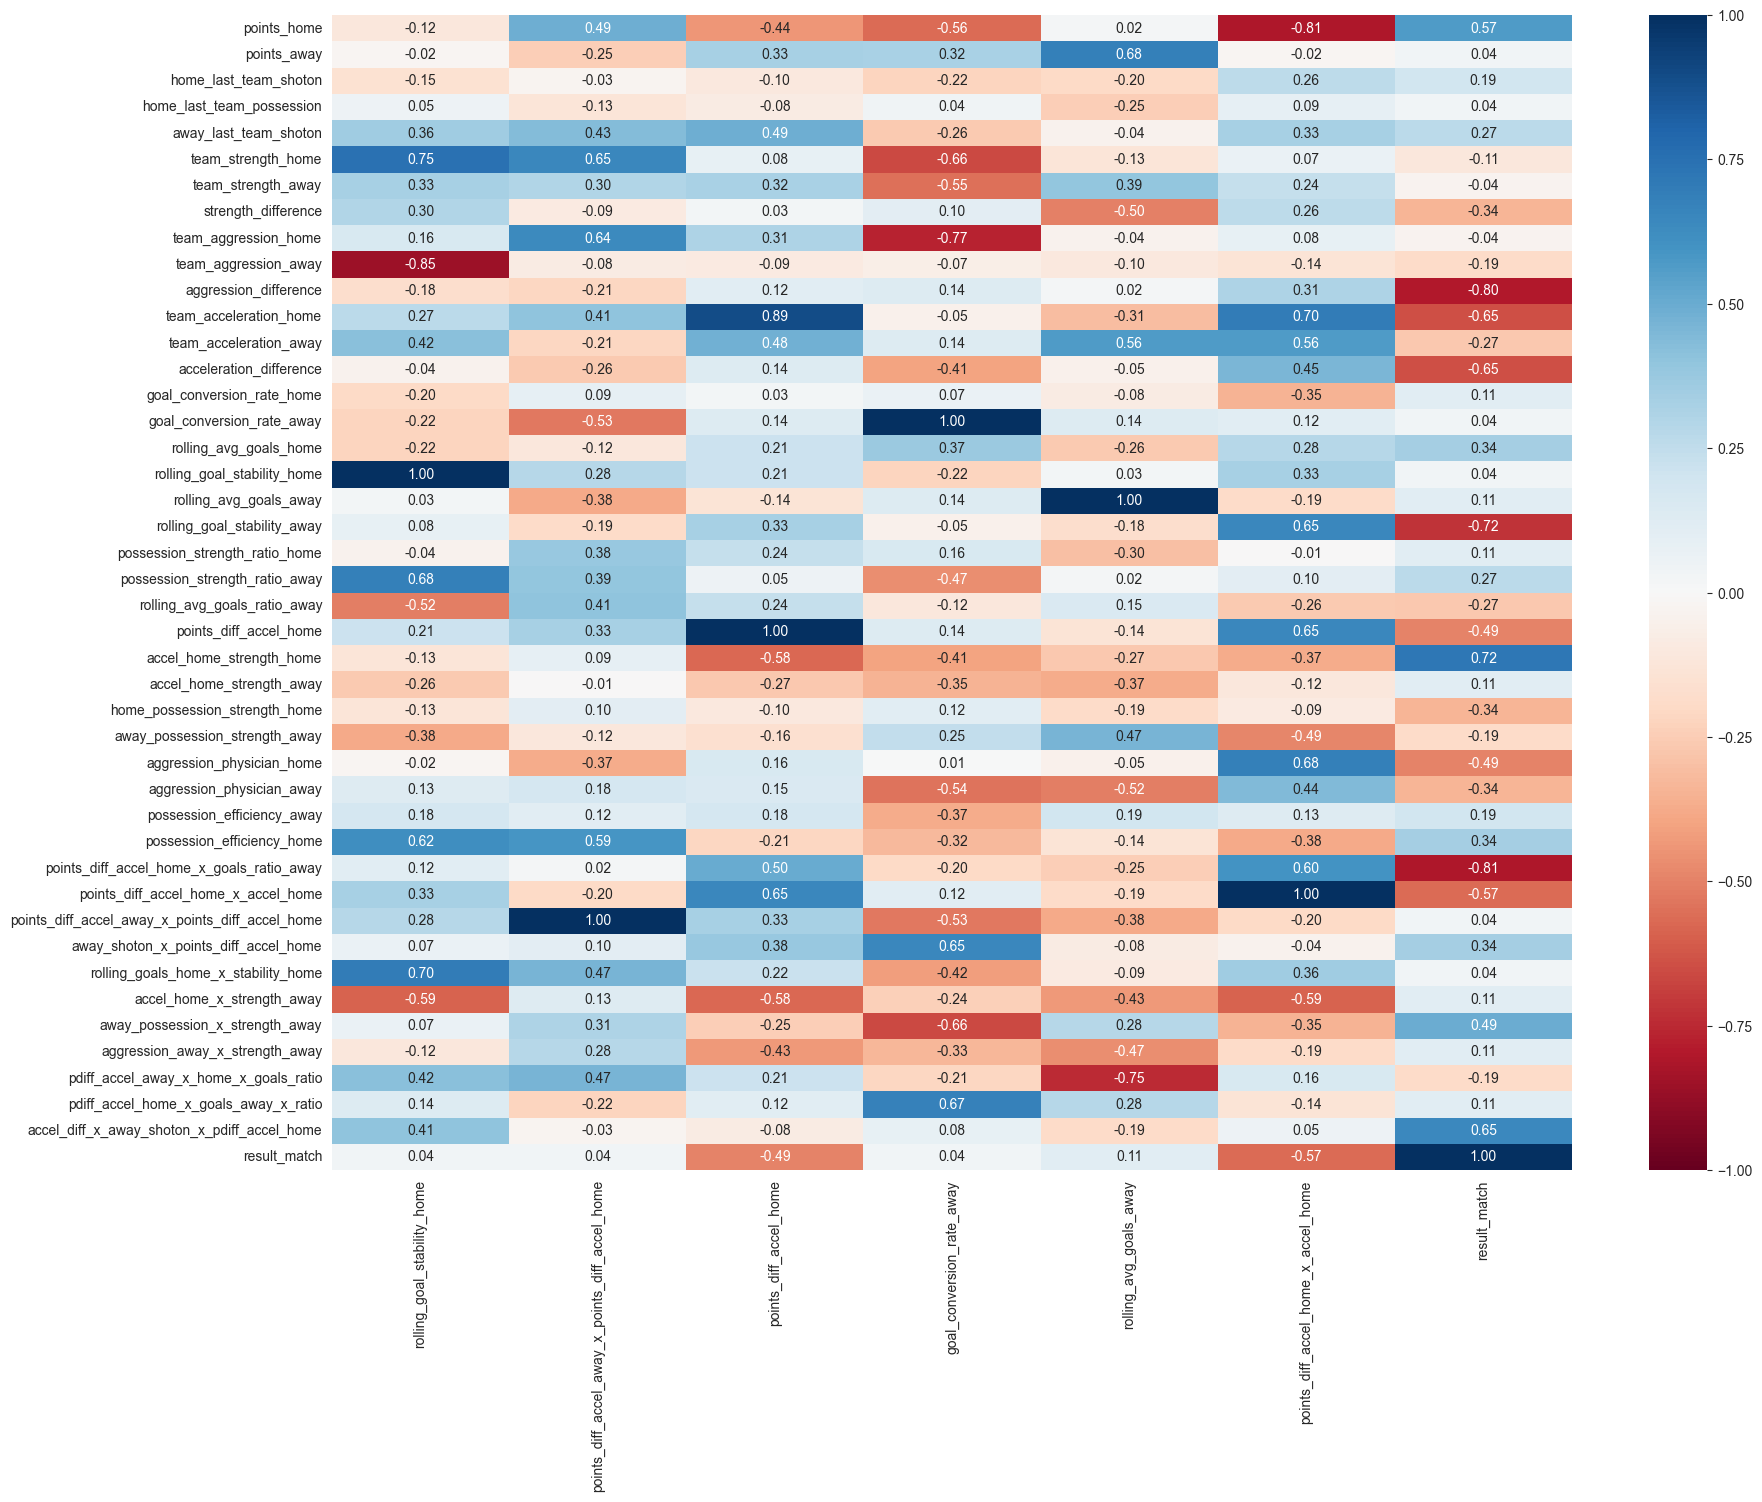

In [10]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(shap_df
            .assign(result_match=y_tst)
            .corr(method='spearman')
            .loc[:,
            ['rolling_goal_stability_home', 'points_diff_accel_away_x_points_diff_accel_home', 'points_diff_accel_home',
             'goal_conversion_rate_away', 'rolling_avg_goals_away', 'points_diff_accel_home_x_accel_home',
             'result_match']],
            cmap='RdBu', annot=True, fmt='.2f', vmin=-1, vmax=1, ax=ax
            )
plt.show()

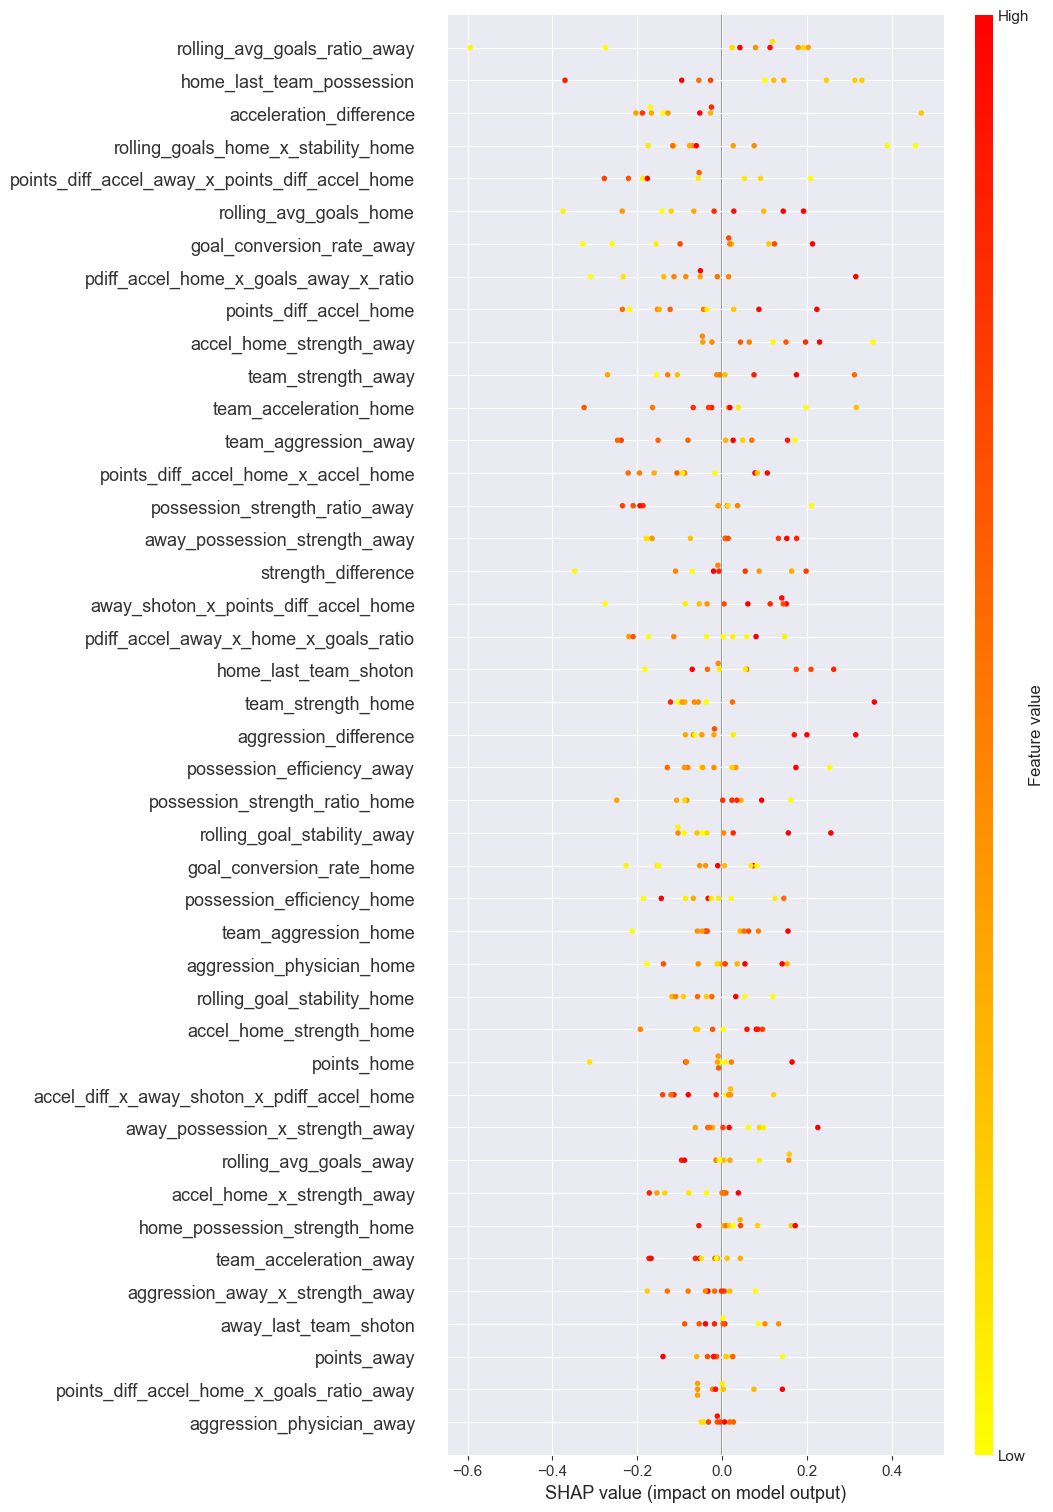

In [11]:
from matplotlib import cm

fig = plt.figure(figsize=(8, 4))
shap.plots.beeswarm(vals, max_display=len(X_tst.columns), color=cm.autumn_r)

In [12]:
booster = model.get_booster()

shap_preds = booster.predict(DMatrix(X_tst), pred_contribs=True)
shap_preds

array([[-1.10707767e-02, -5.98846525e-02, -9.21011157e-03,
        -9.52172056e-02, -3.91154028e-02,  2.43854485e-02,
        -1.05539560e-01, -7.51441251e-03, -3.87315005e-02,
         8.05103034e-03,  3.15074950e-01,  1.51912142e-02,
        -4.90176827e-02, -1.87794432e-01, -5.28392121e-02,
         2.21670531e-02, -1.20077468e-01, -2.41091847e-02,
        -1.85820460e-03, -4.57921177e-02,  9.32282656e-02,
        -1.86145782e-01,  1.79356307e-01, -1.22511052e-01,
        -6.23869300e-02, -4.54897359e-02,  1.72393948e-01,
         1.32823393e-01,  7.18278065e-03, -4.28805090e-02,
        -8.90380666e-02,  1.45473450e-01, -2.25354657e-02,
        -1.06371567e-01,  5.26809916e-02,  6.06711209e-02,
         2.62585003e-02, -1.36643648e-04, -3.36763859e-02,
         1.80986598e-02,  2.52885185e-02, -1.12757226e-02,
        -1.20499507e-01,  4.93906029e-02],
       [ 2.18277387e-02, -1.29883345e-02, -1.81675971e-01,
        -2.70041041e-02, -1.79988667e-02, -5.61791845e-02,
        -5.55

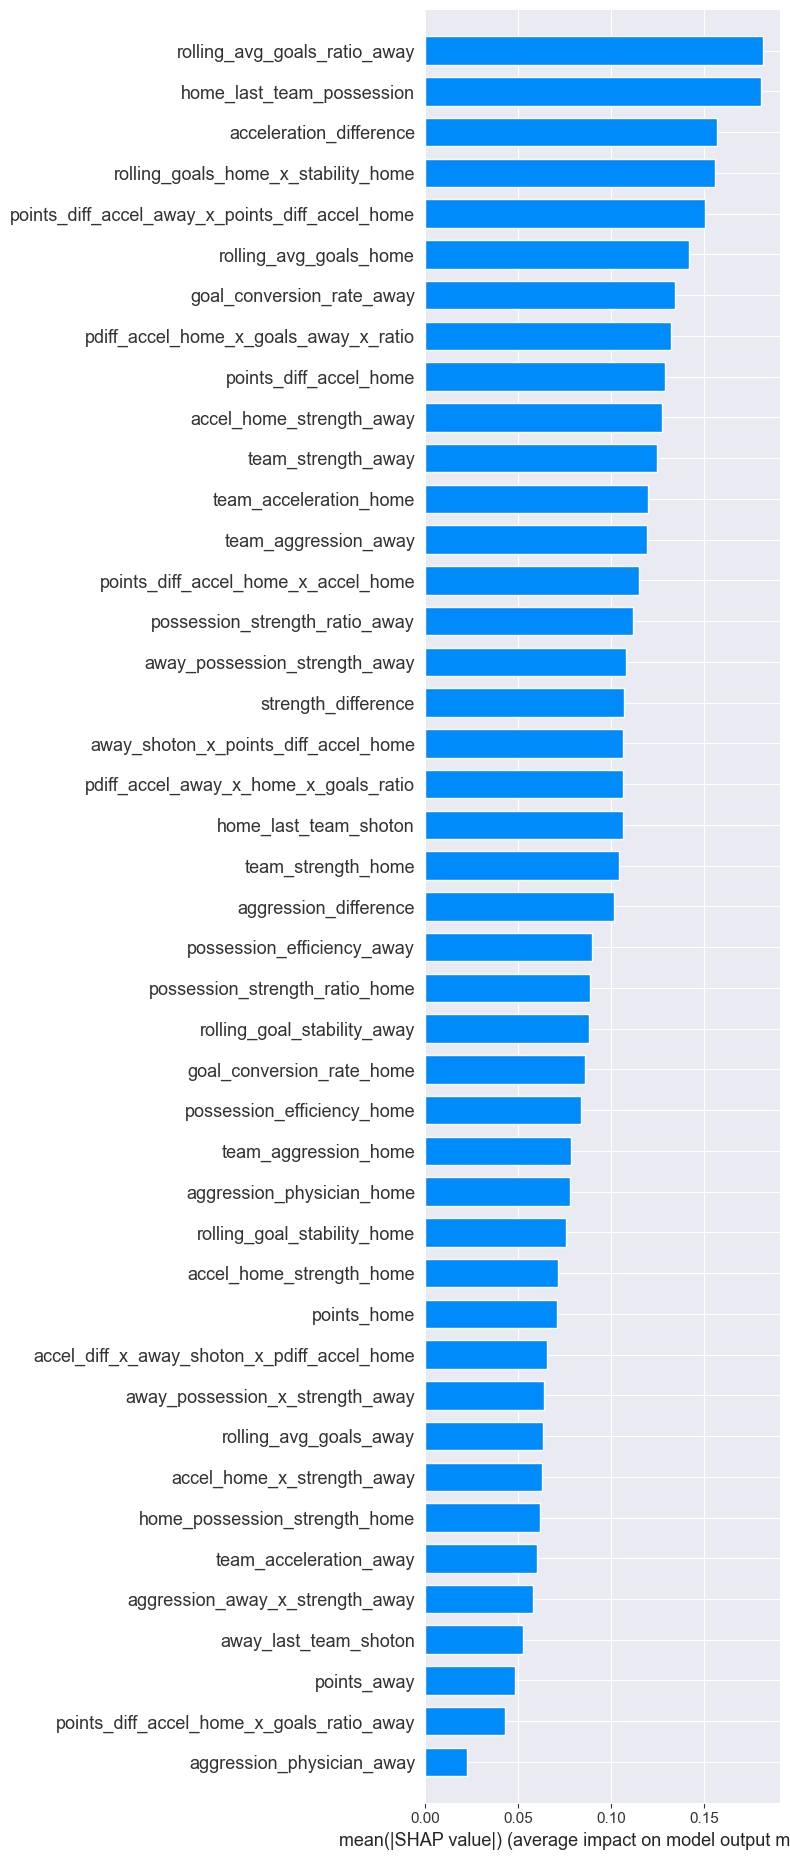

In [13]:
shap.summary_plot(shap_preds[:, :-1], features=X_tst, plot_type="bar", max_display=len(X_tst.columns))

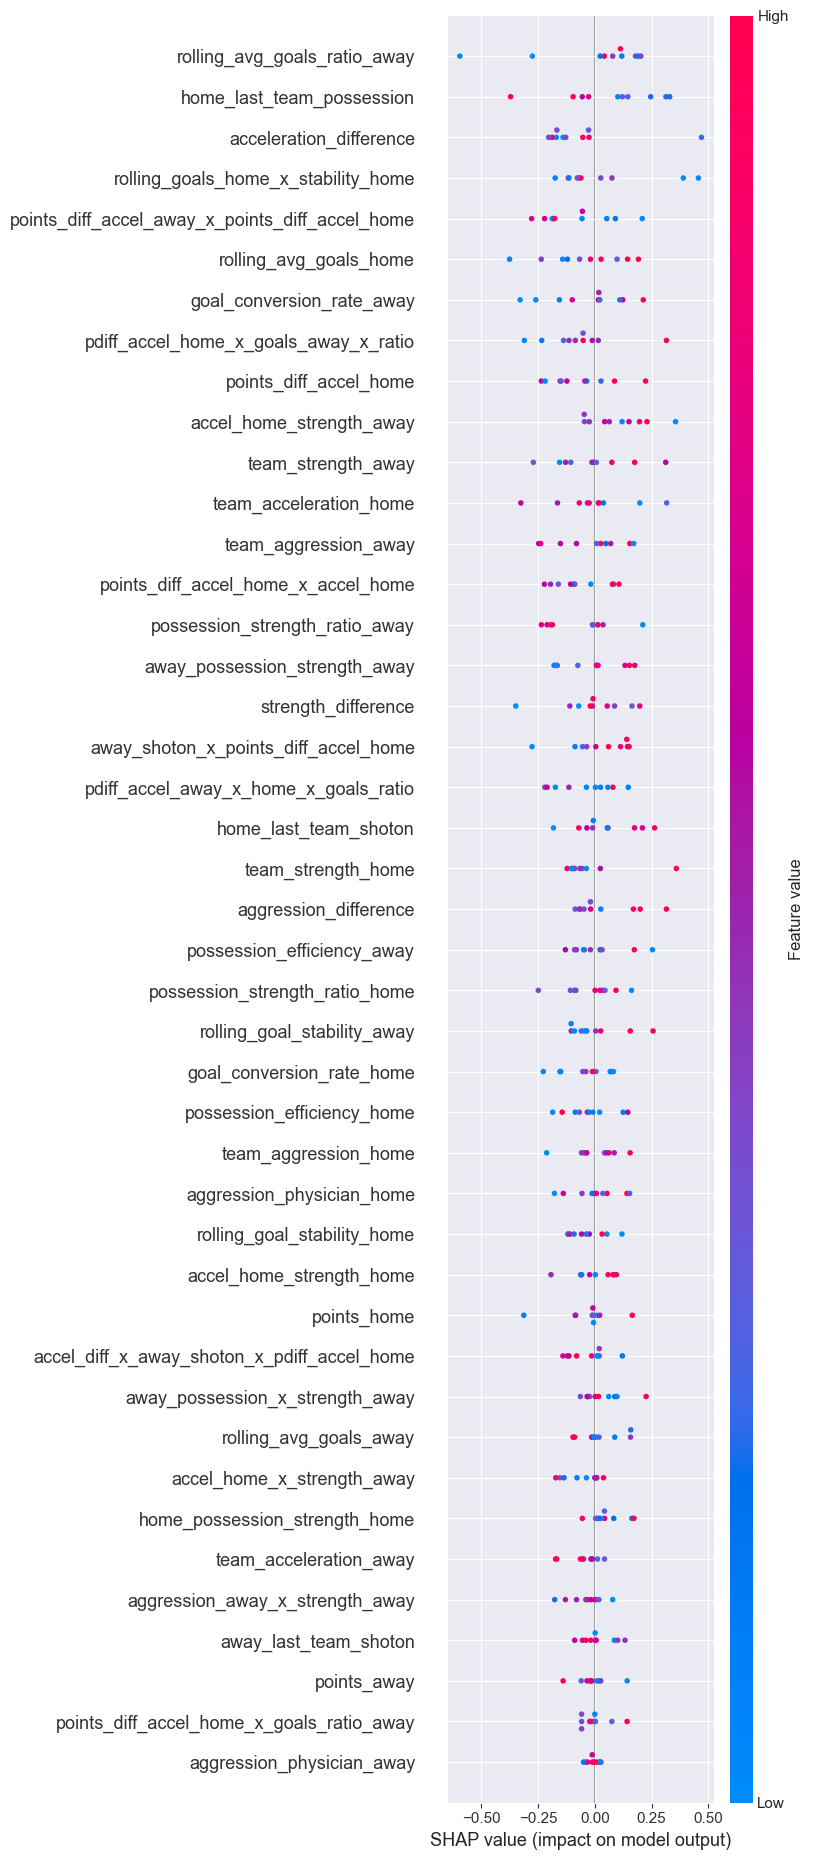

In [14]:
shap.summary_plot(shap_preds[:, :-1], features=X_tst, max_display=len(X_tst.columns))

In [15]:
# shap_df = pd.DataFrame(vals.values, columns=X_tst.columns)

abs_shap_values = np.abs(vals.values)
mean_abs_shap_values = np.mean(abs_shap_values, axis=0)
np.sort(mean_abs_shap_values)

array([0.02251128, 0.04322205, 0.04829008, 0.05300276, 0.05799963,
       0.06008137, 0.061646  , 0.06320055, 0.06336463, 0.06402273,
       0.06539076, 0.07106899, 0.07164712, 0.0759878 , 0.07780547,
       0.07879953, 0.08416348, 0.08599146, 0.08804747, 0.08868162,
       0.08966614, 0.10145791, 0.10460744, 0.10627963, 0.1066713 ,
       0.10671794, 0.10692708, 0.10817637, 0.11164609, 0.11494726,
       0.11941087, 0.12001008, 0.12465268, 0.12759252, 0.12928954,
       0.13242155, 0.13453591, 0.14193913, 0.15059301, 0.15580723,
       0.15684739, 0.18042035, 0.18180144], dtype=float32)

In [16]:
faulty_columns = np.where(mean_abs_shap_values < 0.006)[0]
faulty_columns

array([], dtype=int64)

In [17]:
np.where(mean_abs_shap_values == 0)

(array([], dtype=int64),)

In [18]:
mean_abs_shap_values

array([0.07106899, 0.04829008, 0.10627963, 0.18042035, 0.05300276,
       0.10460744, 0.12465268, 0.10692708, 0.07879953, 0.11941087,
       0.10145791, 0.12001008, 0.06008137, 0.15684739, 0.08599146,
       0.13453591, 0.14193913, 0.0759878 , 0.06336463, 0.08804747,
       0.08868162, 0.11164609, 0.18180144, 0.12928954, 0.07164712,
       0.12759252, 0.061646  , 0.10817637, 0.07780547, 0.02251128,
       0.08966614, 0.08416348, 0.04322205, 0.11494726, 0.15059301,
       0.10671794, 0.15580723, 0.06320055, 0.06402273, 0.05799963,
       0.1066713 , 0.13242155, 0.06539076], dtype=float32)

In [19]:
X_tst.columns[faulty_columns]

Index([], dtype='object')

In [8]:
features = ['team_aggression_home', 'team_acceleration_away', 'aggression_difference', 'points_diff_accel_home',
            'momentum_multiplier', 'away_last_team_goal']
fig = plot_histograms(shap_df, features, shap_df.iloc[0], title='SHAP values for row 0')
plt.show()

/tmp/ipykernel_352572/1672211698.py:26: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist = (df[columns].hist(ax=ax, color='#bbb'))


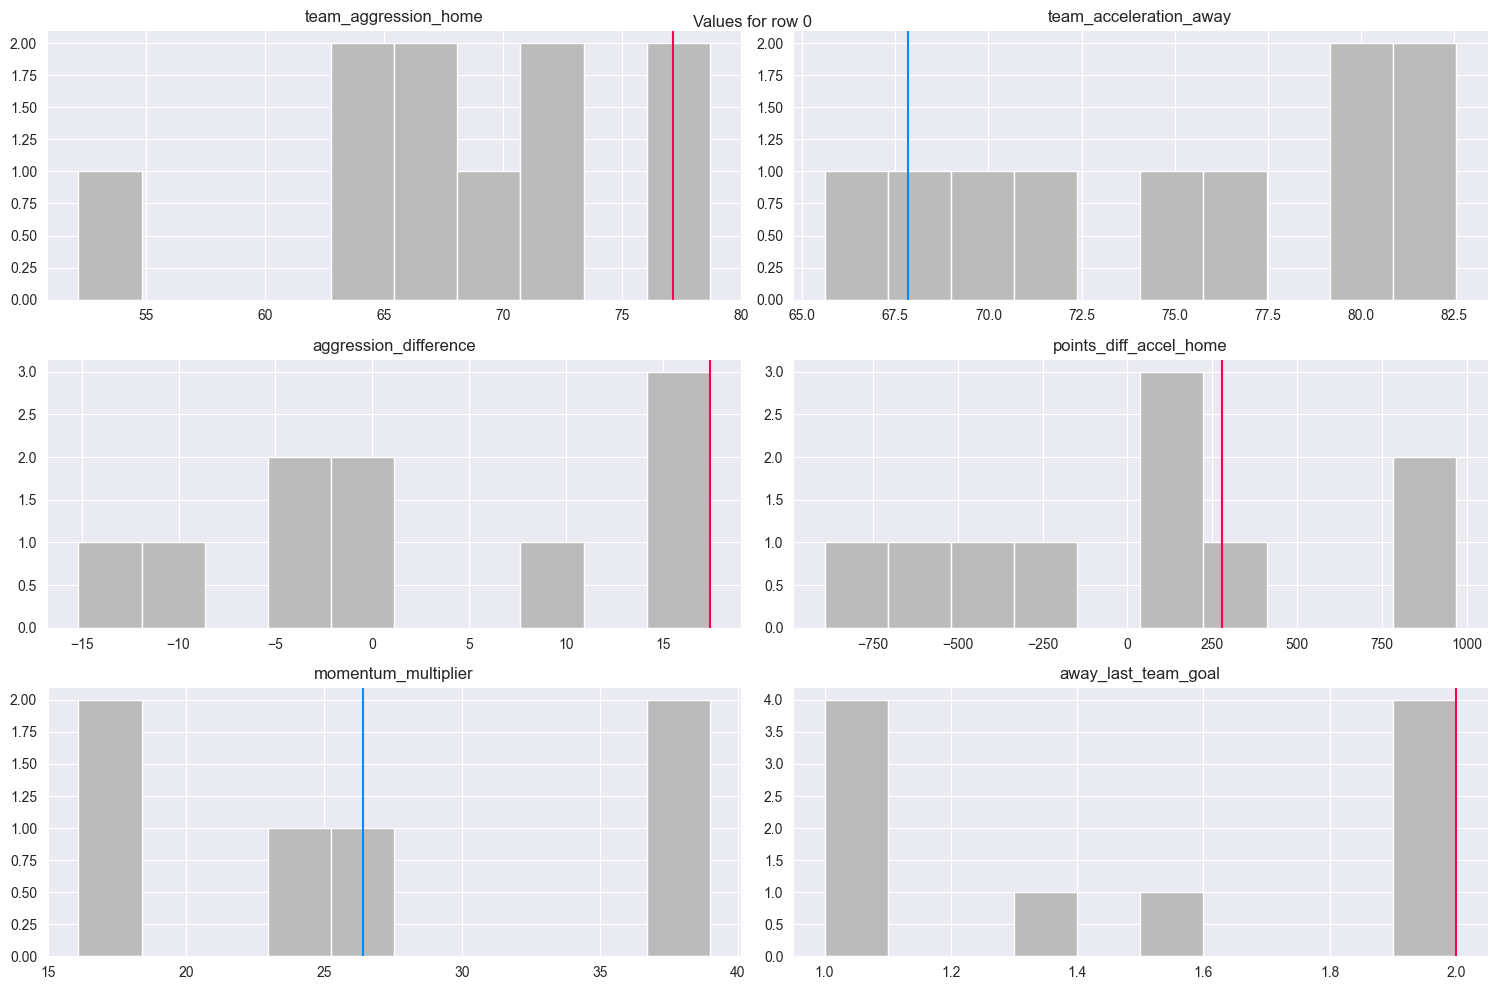

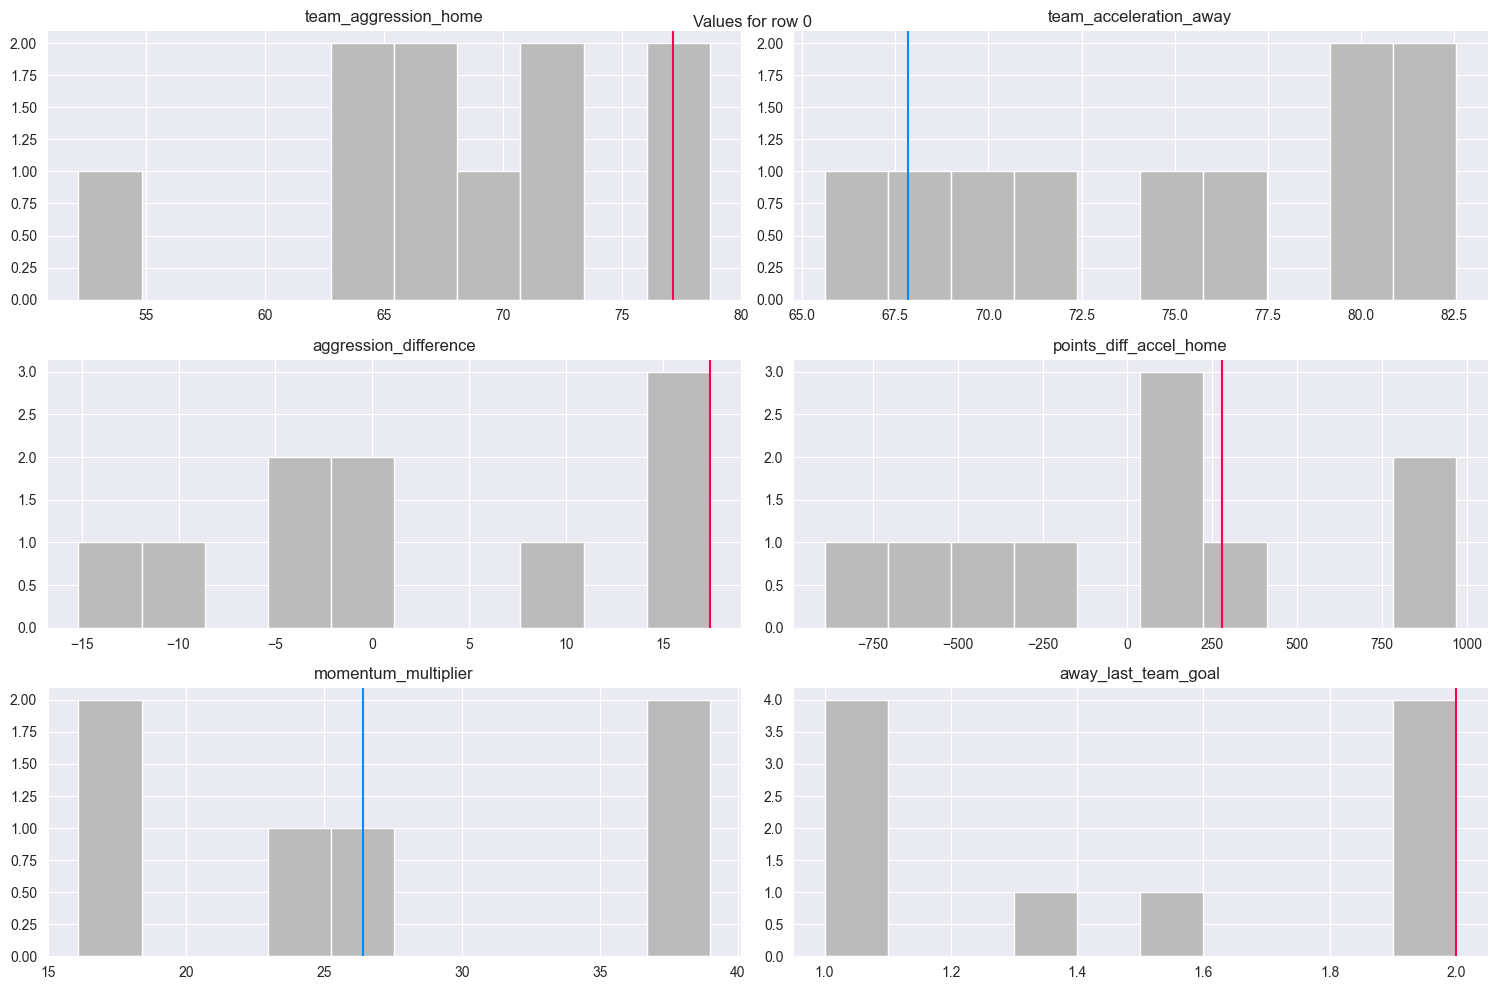

In [76]:
fig = plot_histograms(X_tst, features, X_tst.iloc[0], title='Values for row 0', color='mean')
plt.show()

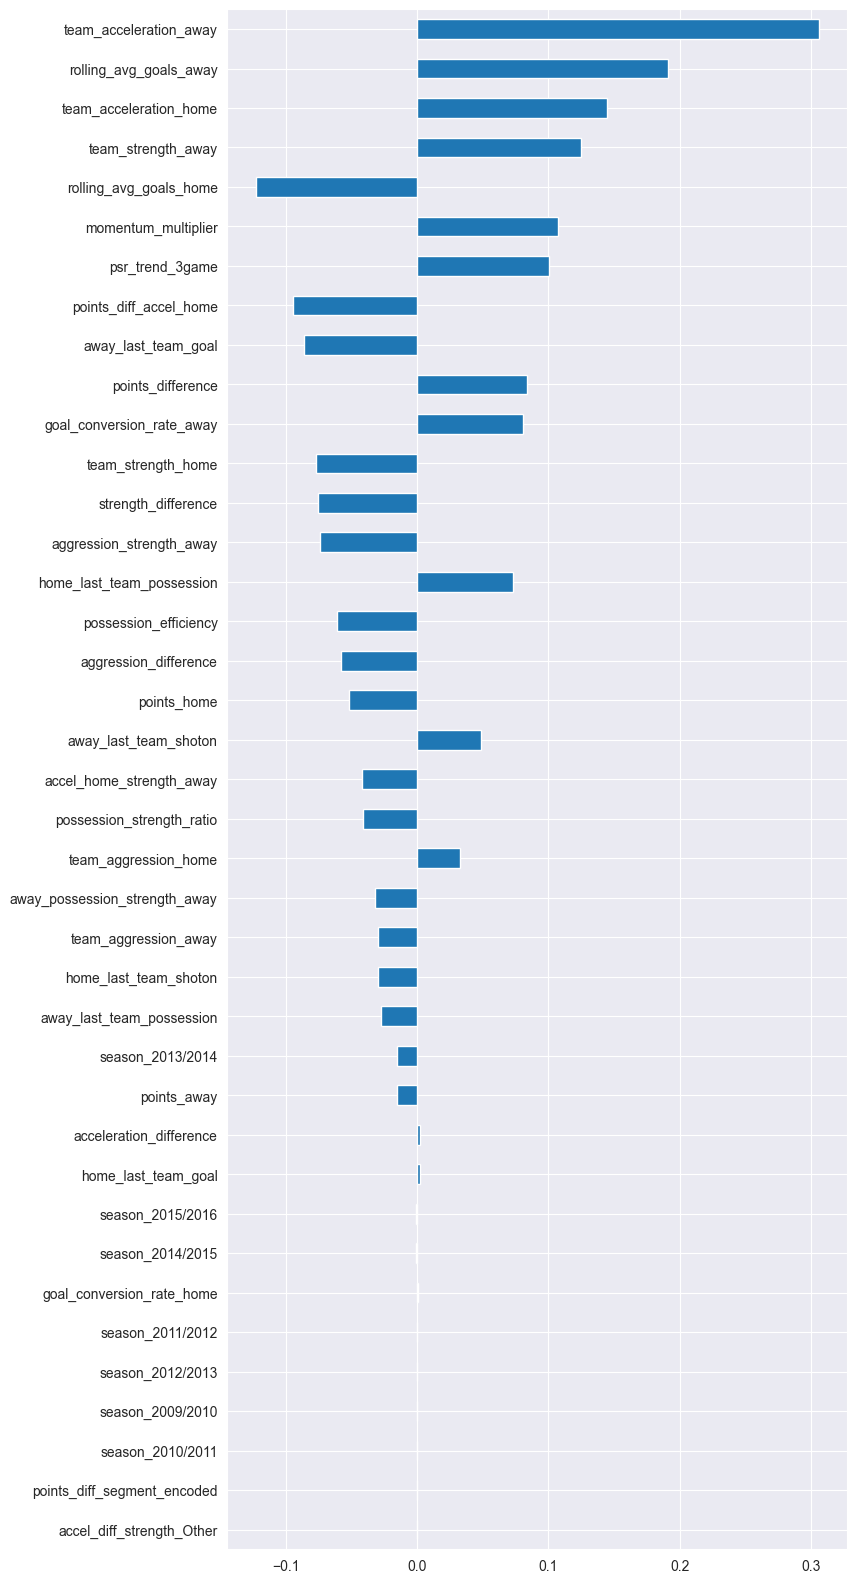

In [81]:
fig, ax = plt.subplots(figsize=(8, 20))
(pd.Series(vals.values[4], index=X_tst.columns)
 .sort_values(key=np.abs)
 .plot.barh(ax=ax)
 )
plt.show()

In [11]:
target_values_count = y_trn.value_counts()

In [12]:
ratio = target_values_count[0] / target_values_count[1]

np.int64(908)

In [13]:
target_values_count[1]

np.int64(731)